In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    GlobalAveragePooling1D,
)
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2

In [4]:
import os
os.getcwd()

'c:\\Users\\Lilu\\Desktop\\classificaton_var_stars'

In [3]:
os.chdir('..\\..\\..\\')

In [5]:
os.chdir('data')

In [7]:
# Подготовка данных для модели
y_labels = pd.read_csv('y_labels_100thsnd.csv')

cnn_arrays = np.load('shuffled_combined_100thsnd.npz')
X_ts = cnn_arrays['X']
ids_ts = cnn_arrays['ids']

In [8]:
# Создание индексов для корректного разделения
indices = np.arange(len(X_ts))
# Стратифицированное разделение с сохранением индексов
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_ts,
    y_labels['main_class'].values,
    indices,
    test_size=0.2,
    stratify=y_labels['main_class'],
    random_state=42
)

In [9]:
# Кодирование целевых переменных
ohe_main = OneHotEncoder(sparse_output=False)
y_main = ohe_main.fit_transform(y_labels[['main_class']])

In [10]:
# Вычисление весов классов до SMOTE
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_labels['main_class']),
    y=y_labels['main_class']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 0.6947000327833024,
 1: 5.210819672131148,
 2: 0.43929607960565714,
 3: 1.2142875334267158,
 4: 3.721287804878049}

In [11]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[['ECLIPSING' 21962]
 ['ERUPTIVE' 2928]
 ['PULSATING' 34731]
 ['ROTATING' 12565]
 ['cataclysmic' 4100]]


In [12]:
n_samples, timesteps, features = X_train.shape

In [12]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
# Коллбэк для сохранения по F1
checkpoint_f1 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/11best_f1.keras',  
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Коллбэк для сохранения по val_loss
checkpoint_loss = ModelCheckpoint(
    filepath='/content/drive/MyDrive/11best_loss.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    TensorBoard(log_dir='./logs'),
    checkpoint_f1,
    checkpoint_loss
]

In [13]:
# Преобразование меток в one-hot
y_train_resampled_onehot = ohe_main.transform(pd.DataFrame(y_train, columns=['main_class']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val, columns=['main_class']))

In [14]:
class TemporalScaler:
    def __init__(self):
        self.scalers = []

    def fit(self, X_train):
        """Обучение на тренировочных данных"""
        self.scalers = []
        for feat_idx in range(X_train.shape[2]):
            scaler = StandardScaler()
            scaler.fit(X_train[:, :, feat_idx].reshape(-1, 1))
            self.scalers.append(scaler)
        return self

    def transform(self, X):
        """Применение к любым данным"""
        X_scaled = np.zeros_like(X)
        for feat_idx in range(X.shape[2]):
            X_scaled[:, :, feat_idx] = self.scalers[feat_idx].transform(
                X[:, :, feat_idx].reshape(-1, 1)
            ).reshape(X.shape[0], X.shape[1])
        return X_scaled

# Использование
scaler = TemporalScaler()
scaler.fit(X_train)  

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
def residual_block(x, filters, dilation_rate, kernel_size=3):
    # Residual block с расширенной сверткой
    original_x = x
    x = Conv1D(filters*2, kernel_size,
              padding='causal',
              dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    # Gate branch
    gated = Conv1D(filters*2, kernel_size,
                  padding='causal',
                  dilation_rate=dilation_rate)(original_x)
    gated = BatchNormalization()(gated)
    gated = Activation('sigmoid')(gated)

    # Комбинирование
    x = Multiply()([x, gated])

    # Residual connection
    x = Conv1D(filters, 1, padding='same')(x)
    res = Add()([original_x, x])

    return res

def build_wavenet_model(input_shape, num_classes):
    # Вход для временных рядов
    ts_input = Input(shape=input_shape, name='ts_input')

    # Начальный слой
    x = Conv1D(64, 3, padding='causal')(ts_input)

    # Стек residual блоков с экспоненциально растущими dilation rates
    dilation_rates = [1, 2, 4, 8, 16, 32]
    for i, rate in enumerate(dilation_rates):
        x = residual_block(x, filters=64, dilation_rate=rate)
        x = Dropout(0.2)(x)

    # Финальные слои обработки временных рядов
    x = Conv1D(128, 3, padding='causal')(x)
    x = GlobalAveragePooling1D()(x)

    # Классификатор
    output = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
    output = Dropout(0.4)(output)
    output = Dense(num_classes, activation='softmax')(output)

    return Model(inputs=ts_input, outputs=output)

In [17]:
# Компиляция модели
model = build_wavenet_model(
    input_shape=(timesteps, features),
    num_classes=len(ohe_main.categories_[0])
)
model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[F1Score(average='macro')]
)

In [18]:
# Обучение модели
history = model.fit(
    X_train_scaled,
    y_train_resampled_onehot,
    epochs=50,
    batch_size=128,
    #class_weight=class_weight_dict,
    validation_data=(X_val_scaled, y_val_onehot),
    callbacks=callbacks
)

Epoch 1/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - f1_score: 0.3420 - loss: 1.4932
Epoch 1: val_f1_score improved from -inf to 0.44630, saving model to /content/drive/MyDrive/11best_f1.keras

Epoch 1: val_loss improved from inf to 1.03063, saving model to /content/drive/MyDrive/11best_loss.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 117s 142ms/step - f1_score: 0.3420 - loss: 1.4928 - val_f1_score: 0.4463 - val_loss: 1.0306
Epoch 2/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - f1_score: 0.4526 - loss: 1.0138
Epoch 2: val_f1_score improved from 0.44630 to 0.49520, saving model to /content/drive/MyDrive/11best_f1.keras

Epoch 2: val_loss improved from 1.03063 to 1.01444, saving model to /content/drive/MyDrive/11best_loss.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 109s 116ms/step - f1_score: 0.4526 - loss: 1.0137 - val_f1_score: 0.4952 - val_loss: 1.0144
Epoch 3/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - f1_score: 0.4941 - loss: 0.9574
Epoch 3: val_f1_score improved from 0.49520 to 0.53470, sav

In [ ]:
# Найти индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1, 
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 24
Train F1: 0.6303
Train loss: 0.7808
Validation F1: 0.6074
Validation Loss: 0.8433


In [20]:
pd.DataFrame(history.history).to_csv('/content/drive/MyDrive/history11.csv')

596/596 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


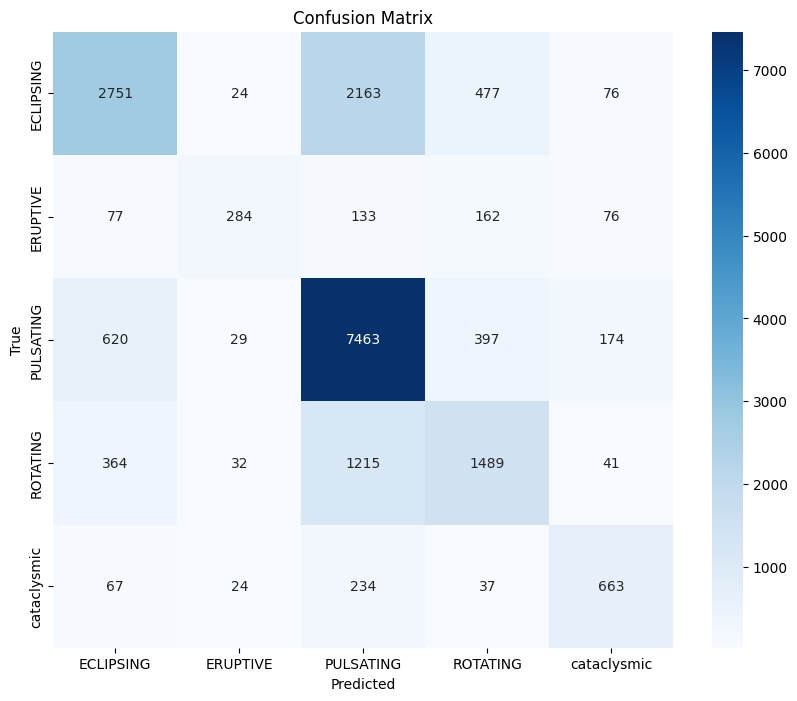

In [ ]:
# Получение предсказаний
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

#  Создание confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

#  Визуализация с нормализацией
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=ohe_main.categories_[0],
           yticklabels=ohe_main.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   ECLIPSING     0.7092    0.5010    0.5872      5491
    ERUPTIVE     0.7226    0.3880    0.5049       732
   PULSATING     0.6659    0.8595    0.7504      8683
    ROTATING     0.5812    0.4741    0.5222      3141
 cataclysmic     0.6437    0.6468    0.6453      1025

    accuracy                         0.6633     19072
   macro avg     0.6645    0.5739    0.6020     19072
weighted avg     0.6654    0.6633    0.6507     19072



In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
# Коллбэк для сохранения по F1
checkpoint_f1 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/22best_f1.keras', 
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Коллбэк для сохранения по val_loss
checkpoint_loss = ModelCheckpoint(
    filepath='/content/drive/MyDrive/22best_loss.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    TensorBoard(log_dir='./logs'),
    checkpoint_f1,
    checkpoint_loss
]

In [2]:
history = pd.read_csv('wavehistory.csv')

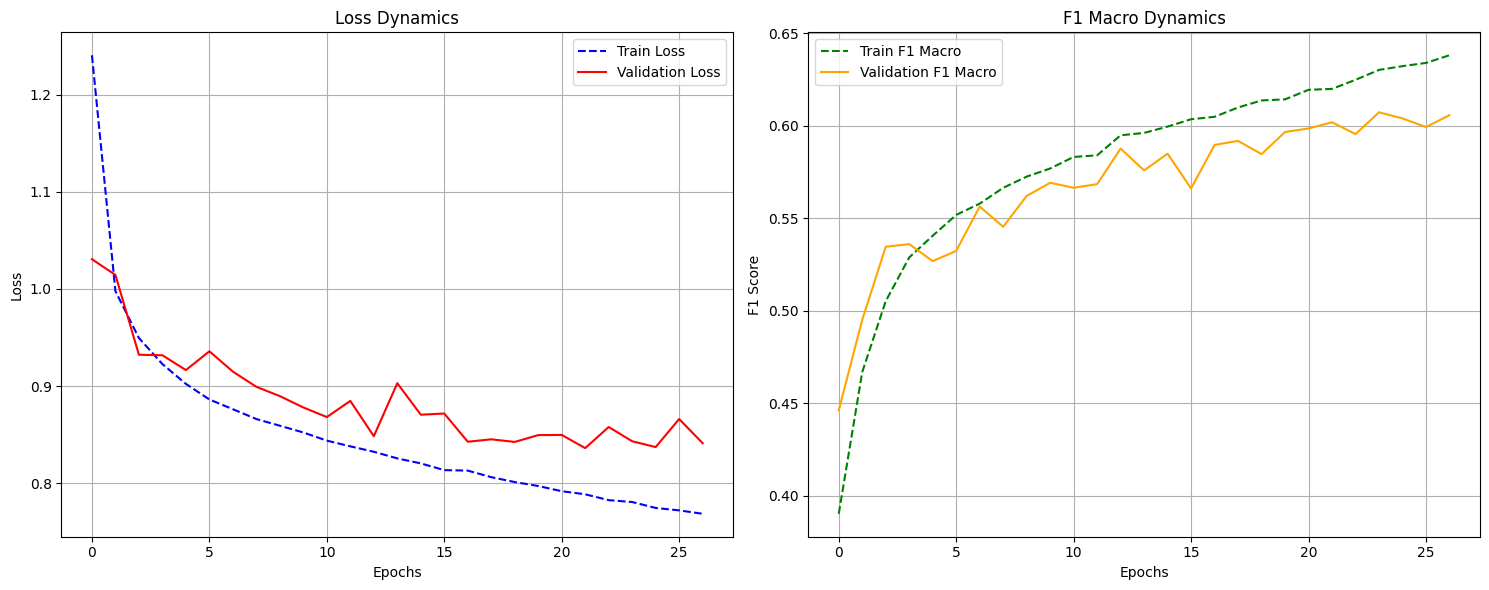

In [4]:
# Создаем фигуру
plt.figure(figsize=(15, 6))

# График для Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', color='red', linestyle='-')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для F1 Macro
plt.subplot(1, 2, 2)
plt.plot(history['f1_score'], label='Train F1 Macro', color='green', linestyle='--')
plt.plot(history['val_f1_score'], label='Validation F1 Macro', color='orange', linestyle='-')
plt.title('F1 Macro Dynamics')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
class PrototypeLayer(layers.Layer):
    def __init__(self, num_prototypes, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_prototypes = num_prototypes
        self.embedding_dim = embedding_dim

    def build(self, input_shape):
        self.prototypes = self.add_weight(
            name="prototypes",
            shape=(self.num_prototypes, self.embedding_dim),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        # Вычисление евклидового расстояния
        expanded_inputs = tf.expand_dims(inputs, 1)
        expanded_prototypes = tf.expand_dims(self.prototypes, 0)
        distances = tf.reduce_sum(
            tf.square(expanded_inputs - expanded_prototypes),
            axis=-1
        )
        return -distances  # отриц расстояние = logits

def build_protonet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Получение фичей
    x = layers.Conv1D(128, 7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(256, 7, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.MaxPooling1D(2)(x)

    residual = x
    x = layers.MultiHeadAttention(num_heads=8, key_dim=32)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + residual)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Проекция эмбеддингов
    embeddings = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    embeddings = layers.Dropout(0.5)(embeddings)

    # Сравнение прототипов
    logits = PrototypeLayer(num_prototypes=num_classes,
                           embedding_dim=512)(embeddings)

    return Model(inputs=inputs, outputs=logits)

# Компиляция модели
model = build_protonet(
    input_shape=(timesteps, features),
    num_classes=len(ohe_main.categories_[0])
)

model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[F1Score(average='macro')]
        )



# Обучение модели
history = model.fit(
    X_train_scaled,
    y_train_resampled_onehot,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_scaled, y_val_onehot),
    callbacks=callbacks
)

Epoch 1/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - f1_score: 0.3677 - loss: 1.7023
Epoch 1: val_f1_score improved from -inf to 0.48654, saving model to /content/drive/MyDrive/22best_f1.keras

Epoch 1: val_loss improved from inf to 1.04644, saving model to /content/drive/MyDrive/22best_loss.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 105s 158ms/step - f1_score: 0.3678 - loss: 1.7016 - val_f1_score: 0.4865 - val_loss: 1.0464
Epoch 2/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - f1_score: 0.5052 - loss: 0.9818
Epoch 2: val_f1_score improved from 0.48654 to 0.51199, saving model to /content/drive/MyDrive/22best_f1.keras

Epoch 2: val_loss improved from 1.04644 to 0.94881, saving model to /content/drive/MyDrive/22best_loss.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 93s 155ms/step - f1_score: 0.5052 - loss: 0.9818 - val_f1_score: 0.5120 - val_loss: 0.9488
Epoch 3/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - f1_score: 0.5332 - loss: 0.9500
Epoch 3: val_f1_score improved from 0.51199 to 0.52574, savi

In [ ]:
# Найти индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1, 
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 19
Train F1: 0.6101
Train loss: 0.8212
Validation F1: 0.5879
Validation Loss: 0.8721


In [27]:
pd.DataFrame(history.history).to_csv('/content/drive/MyDrive/history22.csv')

596/596 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step


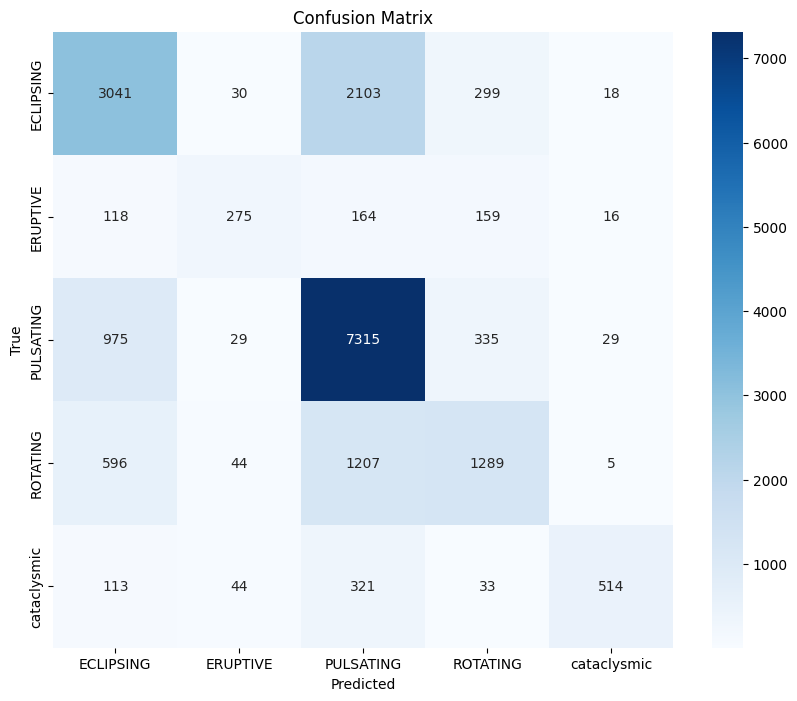

In [ ]:
# Получение предсказаний
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

# 3Создание confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Визуализация с нормализацией
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
           annot=True,
           fmt='d',
           cmap='Blues',
           xticklabels=ohe_main.categories_[0],
           yticklabels=ohe_main.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   ECLIPSING     0.6279    0.5538    0.5885      5491
    ERUPTIVE     0.6517    0.3757    0.4766       732
   PULSATING     0.6584    0.8425    0.7392      8683
    ROTATING     0.6095    0.4104    0.4905      3141
 cataclysmic     0.8832    0.5015    0.6397      1025

    accuracy                         0.6520     19072
   macro avg     0.6861    0.5368    0.5869     19072
weighted avg     0.6534    0.6520    0.6394     19072

